#  Image caption Task 7

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
import pickle
from PIL import Image
#from cache import cache

In [3]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Loading coco

In [4]:
from pycocotools.coco import COCO

coco = COCO('/Users/mengyue/Desktop/24Spring/INFO6106/W9L2coco/coco/annotations/captions_train2017.json')

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


Get the images and annotations:

In [5]:
from pathlib import Path
from pycocotools.coco import COCO
dataDir=Path('coco/train2017')
annFile = Path('coco/annotations/person_keypoints_train2017.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])
imgs

loading annotations into memory...
Done (t=3.39s)
creating index...
index created!


[{'license': 3,
  'file_name': '000000516168.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000516168.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-25 21:03:34',
  'flickr_url': 'http://farm3.staticflickr.com/2379/2293730995_e2381ffa38_z.jpg',
  'id': 516168},
 {'license': 4,
  'file_name': '000000547503.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000547503.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:21',
  'flickr_url': 'http://farm1.staticflickr.com/178/423174638_1c6245ee20_z.jpg',
  'id': 547503},
 {'license': 4,
  'file_name': '000000475546.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000475546.jpg',
  'height': 375,
  'width': 500,
  'date_captured': '2013-11-25 21:20:23',
  'flickr_url': 'http://farm1.staticflickr.com/167/423175046_6cd9d0205a_z.jpg',
  'id': 475546}]

### coco train_images_file

In [6]:
import json

def file_read(fname):
    content_array = []
    with open(fname) as f:
        #Content_list is the list that contains the read lines.     
        for line in f:
            content_array.append(line[:-1])
        return content_array

#train_images_file = '/Users/dino/Documents/info7610/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
#train_images_file = 'D:/user/docs/NU/_Info7610/datasets/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images_file = open('coco/annotations/instances_train2017.json')
train_images_json = json.load(train_images_file)

In [7]:
# Iterating through the json
for i in train_images_json['images']:
    #print(i['file_name'])
    print(i)
    break

{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


## train captions  

In [8]:
train_captions_file = open('coco/annotations/captions_train2017.json')
train_captions_json = json.load(train_captions_file)

In [9]:
# Iterating through the json
for i in train_captions_json['annotations']:
    #print(i['file_name'])
    print(i)
    break

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


In [10]:
train_filenames = []
for i in train_images_json['images']:
    train_filenames.append((i['file_name'], i['id']))
    
train_captions = []
for i in train_captions_json['annotations']:
    train_captions.append((i['image_id'], i['caption']))
    
ids_files = dict()
for i in train_filenames:
    ids_files[i[1]] = i[0]
    
ids_captions = dict()
for i in train_captions:
    ids_captions[i[0]] = i[1]
    
train_filenames = []
train_captions = []
for k,v in ids_files.items():
    train_filenames.append(v)
    train_captions.append(ids_captions[k])
    
list(zip(train_filenames[:10], train_captions[:10]))

[('000000391895.jpg',
  'A man in a red shirt and a red hat is on a motorcycle on a hill side.'),
 ('000000522418.jpg',
  "A woman marking a cake with the back of a chef's knife. "),
 ('000000184613.jpg',
  'A boy holding an umbrella while standing next to livestock.'),
 ('000000318219.jpg', 'a young kid with head phones on using a computer '),
 ('000000554625.jpg',
  'A small child wearing headphones plays on the computer.'),
 ('000000574769.jpg', 'A woman is holding a cat in her kitchen.'),
 ('000000060623.jpg',
  'A little girl is getting ready to blow out a candle on a small dessert.'),
 ('000000309022.jpg', 'Food cooks in a pot on a stove in a kitchen.'),
 ('000000005802.jpg', 'two men in white shirts in a large steel kitchen'),
 ('000000222564.jpg',
  'Two cooks are near the stove in a stainless steel kitchen.')]

### validation data

In [11]:
val_images_path =  'coco/val2017'
val_images_file = open('coco/annotations/instances_val2017.json')
val_images_json = json.load(val_images_file)

val_captions_file = open('coco/annotations/captions_val2017.json')
val_captions_json = json.load(val_captions_file)

In [12]:
from os.path import exists

val_filenames = []
for i in val_images_json['images']:
    val_filenames.append((i['file_name'], i['id'])) 
#print(val_filenames[:10])
    
val_captions = []
for i in val_captions_json['annotations']:
    val_captions.append((i['image_id'], i['caption']))   
#print(val_captions[:10])
    
ids_files = dict()
for i in val_filenames:
    ids_files[i[1]] = i[0]
    
ids_captions = dict()
for i in val_captions:
    ids_captions[i[0]] = i[1]
   
i = 0
for k,v in ids_captions.items():
    print(k, v)
    i += 1
    if 10 < i:
        break
    
val_filenames = []
val_captions = []
for k,v in ids_files.items():
    if k in ids_captions and exists('coco/test2017'):
        val_filenames.append(v)
        val_captions.append(ids_captions[k])
    
list(zip(val_filenames[:10], val_captions[:10]))

179765 A motorcycle with its brake extended standing outside
190236 A desk and chair in an office cubicle.
331352 Off white toilet with a faucet and controls. 
517069 A woman and another woman waiting at a stop.
182417 This is a picture of an extremely fancy desert.
46378 A cat eating a dead bird on the ground.
93437 An old man standing in a kitchen posing for a picture.
172330 A grey and white cat standing in the grass in a parking lot. 
472678 A desk with two monitors depicting security cameras.
314251 A group of scooters rides down a street
223747 Man sleeping next to a cat on a bed. 


[('000000397133.jpg',
  'A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.'),
 ('000000037777.jpg', 'A kitchen that has a bowl of fruit on the table.'),
 ('000000252219.jpg',
  'People are walking on the street by a homeless person.'),
 ('000000087038.jpg', 'a man falls off his skateboard in a skate park.'),
 ('000000174482.jpg', 'a bike sits parked next to a street '),
 ('000000403385.jpg',
  'A very big whit rest room with a shabby looking shower.'),
 ('000000006818.jpg',
  'This picture looks like a janitors closet with buckets on the floor.'),
 ('000000480985.jpg', 'The front end of a red motorcycle that is on display.'),
 ('000000458054.jpg', 'LOTS OF BROKEN TOILETS SITTING OUT ON A LAWN'),
 ('000000331352.jpg', 'Off white toilet with a faucet and controls. ')]

In [13]:
len(train_filenames), len(train_captions)

(118287, 118287)

## load img

In [14]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)
        
    # paste im2 on im1 
    #Image.paste(im1, im2, (50, 125))
    
    # rotate 180 deg counter clockwise 
    #img = img.rotate(180, Image.NEAREST, expand = 1) 

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [15]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        # use this for coco
        coco_dir = dataDir
        # filename = filenames_train[idx]
        # captions = captions_train[idx]
        # use this for flickr8k
        #filename = image_caption[idx][0]
        #caption = image_caption[idx][1]
        filename = train_filenames[idx]
        caption = train_captions[idx]
    else:
        # Use an image from the validation-set.
        # use this for coco
        # coco_dir = coco.val_dir
        coco_dir = val_images_path
        #filename = image_caption[idx]
        #caption = image_caption[idx]
        filename = val_filenames[idx]
        caption = val_captions[idx]

    # Path for the image-file.
    # use this for coco
    path = os.path.join(coco_dir, filename)
    # use this for 
    

    
    # path = os.path.join(train_images_path, filename)

    # Print the captions for this image.
    # use this for coco (in coco, each image can have multiple captions)
    #for caption in captions:
    #    print(caption)
    # use this for flickr8k
    print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

## Example Image
Show an example image and captions from the training-set.

In [16]:
train_filenames[4], train_captions[4]

('000000554625.jpg', 'A small child wearing headphones plays on the computer.')

A small child wearing headphones plays on the computer.


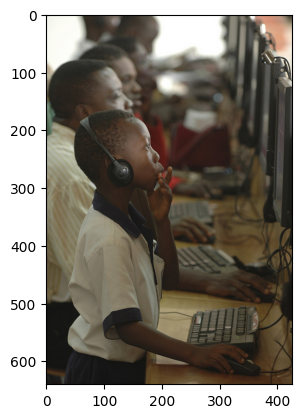

In [17]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
show_image(idx=4, train=True)


# With VGG16

In [18]:
image_model = VGG16(include_top=True, weights='imagenet')

In [19]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We will use the output of the layer prior to the final classification-layer which is named fc2. This is a fully-connected (or dense) layer

In [20]:
transfer_layer = image_model.get_layer('fc2')

We call it the `transfer-layer` because we will transfer its output to another model that creates the image captions.

To do this, first we need to create a new model which has the same input as the original VGG16 model but outputs the transfer-values from the fc2 layer.

In [21]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

The model expects input images to be of this size:

In [22]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

For each input image, the new model will output a vector of transfer-values with this length:

In [23]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

## Processing images
We now make functions for processing all images in our data-set using the pre-trained image-model and saving the transfer-values in a cache-file so they can be reloaded quickly.

We effectively create a new data-set of the transfer-values. This is because it takes a long time to process an image in the VGG16 model. We will not be changing all the parameters of the VGG16 model, so every time it processes an image, it gives the exact same result. We need the transfer-values to train the image-captioning model for many epochs, so we save ourselves a lot of time by calculating the transfer-values once and saving them in a cache-file.

This is a helper-function for printing progress.

In [24]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

## the function for processing the given files using the pretrained VGG16-model and returning their transfer-values.

In [25]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on a GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        i = 0
        for filename in filenames[start_index:end_index]:
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            if exists(path):
                img = load_image(path, size=img_size)

                # Save the image for later use.
                image_batch[i] = img
                
                i += 1

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

Let's cache the results of a generic function for reuse:

In [26]:
def cache(cache_path, fn, *args, **kwargs):
    """
    Cache-wrapper for a function or class. If the cache-file exists
    then the data is reloaded and returned, otherwise the function
    is called and the result is saved to cache. The fn-argument can
    also be a class instead, in which case an object-instance is
    created and saved to the cache-file.
    :param cache_path:
        File-path for the cache-file.
    :param fn:
        Function or class to be called.
    :param args:
        Arguments to the function or class-init.
    :param kwargs:
        Keyword arguments to the function or class-init.
    :return:
        The result of calling the function or creating the object-instance.
    """

    # If the cache-file exists.
    if os.path.exists(cache_path):
        # Load the cached data from the file.
        with open(cache_path, mode='rb') as file:
            obj = pickle.load(file)

        print("- Data loaded from cache-file: " + cache_path)
    else:
        # The cache-file does not exist.

        # Call the function / class-init with the supplied arguments.
        obj = fn(*args, **kwargs)

        # Save the data to a cache-file.
        with open(cache_path, mode='wb') as file:
            pickle.dump(obj, file)

        print("- Data saved to cache-file: " + cache_path)

    return obj

In [27]:
def convert_numpy2pickle(in_path, out_path):
    """
    Convert a numpy-file to pickle-file.
    The first version of the cache-function used numpy for saving the data.
    Instead of re-calculating all the data, you can just convert the
    cache-file using this function.
    :param in_path:
        Input file in numpy-format written using numpy.save().
    :param out_path:
        Output file written as a pickle-file.
    :return:
        Nothing.
    """

    # Load the data using numpy.
    data = np.load(in_path)

    # Save the data using pickle.
    with open(out_path, mode='wb') as file:
        pickle.dump(data, file)

Here is an example of using a cache-file (note you *nned* to have a `data` folder in your `C:/Users/<username>` folder):

In [28]:
# This is the function that will only get called if the result
# is not already saved in the cache-file. This would normally
# be a function that takes a long time to compute
def expensive_function(a, b):
    return a * b

print('Computing expensive_function() ...')

# Either load the result from a cache-file if it already exists,
# otherwise calculate expensive_function(a=123, b=456) and
# save the result to the cache-file for next time.
result = cache(cache_path=os.path.join('data', 'cache_expensive_function.pkl'),
               fn=expensive_function, a=123, b=456)

print('result =', result)

Computing expensive_function() ...
- Data loaded from cache-file: data/cache_expensive_function.pkl
result = 56088


This is another example which saves an object to a cache-file.

In [29]:
# We want to cache an object-instance of this class.
# The motivation is to do an expensive computation only once,
# or if we need to persist the data for some other reason.
class ExpensiveClass:
    def __init__(self, c, d):
        self.c = c
        self.d = d
        self.result = c * d

    def print_result(self):
        print('c =', self.c)
        print('d =', self.d)
        print('result = c * d =', self.result)

print('Creating object from ExpensiveClass() ...')

# Either load the object from a cache-file if it already exists,
# otherwise make an object-instance ExpensiveClass(c=123, d=456)
# and save the object to the cache-file for the next time.
obj = cache(cache_path=os.path.join('data', 'cache_ExpensiveClass.pkl'),
            fn=ExpensiveClass, c=123, d=456)

obj.print_result()

Creating object from ExpensiveClass() ...
- Data loaded from cache-file: data/cache_ExpensiveClass.pkl
c = 123
d = 456
result = c * d = 56088


### Miniature-COCO model
So, I love miniature models! They allow you to *understand* and *debug*.

Let's restrict the number of files to process to 1,000 

In [30]:
len(train_filenames), len(train_captions)

(118287, 118287)

In [31]:
train_filenames_mini = train_filenames[0:1000]
train_captions_mini = train_captions[0:1000]

In [32]:
val_filenames_mini = train_filenames[1000:1100]
val_captions_mini = train_captions[1000:1100]

In [33]:
len(train_filenames_mini), len(val_filenames_mini)

(1000, 100)

This is a helper-function for processing all images in the training-set. This saves the transfer-values in a cache-file for fast reloading.

>**Note**: For flickr8 dataset, I use `train_filenames` variable. For coco, I use `filenames_train` variable!

In [34]:
train_images_path= 'coco/train2017'

In [35]:
def process_images_train():
    #print("Processing {0} images in training-set ...".format(len(filenames_train)))
    print("Processing {0} images in training-set ...".format(len(train_filenames_mini)))

    # Path for our cache-file.
    # use this for coco
    #cache_path = os.path.join(coco.data_dir, "transfer_values_train.pkl")
    # use this for flickr8k
    cache_path = os.path.join(train_images_path, "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    # use this for coco
    #transfer_values = c(cache_path=cache_path,
    #                    fn=process_images,
    #                    data_dir=coco.train_dir,
    #                    filenames=filenames_train)
    # use this for flickr8k
    transfer_values = cache(cache_path=cache_path,
                        fn=process_images,
                        data_dir=train_images_path,
                        filenames=train_filenames_mini)

    return transfer_values

For coco, you would also do this for your validation data set.

>**Note**: For flickr8 dataset, I use `val_filenames` variable. For coco, I use `filenames_val` variable!

In [36]:
val_images_path = 'coco/test2017'

In [37]:
def process_images_val():
    #print("Processing {0} images in validation-set ...".format(len(filenames_val)))
    print("Processing {0} images in validation-set ...".format(len(val_filenames_mini)))

    # Path for the cache-file.
    #cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")
    cache_path = os.path.join(val_images_path, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    #transfer_values = cache(cache_path=cache_path,
    #                        fn=process_images,
    #                        data_dir=coco.val_dir,
    #                        filenames=filenames_val)
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=val_images_path,
                            filenames=val_filenames_mini)

    return transfer_values

We now process all images in the training-set through VGG-16 and save the transfer-values to a cache-file. 

For coco and a GTX 1070 GPU, this takes up to an hour. No GPU, and it might need an entire day to run! For the miniature flickr8k corpus (1,000 images instead of 8.000), it takes about 7 minutes (without GPU) and the cache file is about 8MB.

In [38]:
len(train_filenames_mini)

1000

In [39]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 1000 images in training-set ...
- Data loaded from cache-file: coco/train2017/transfer_values_train.pkl
dtype: float16
shape: (1000, 4096)
CPU times: user 545 µs, sys: 2.48 ms, total: 3.03 ms
Wall time: 2.9 ms


Repeat for validation dataset:

In [40]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 100 images in validation-set ...
- Data loaded from cache-file: coco/test2017/transfer_values_val.pkl
dtype: float16
shape: (100, 4096)
CPU times: user 493 µs, sys: 932 µs, total: 1.42 ms
Wall time: 1.41 ms


## Tokenizing
We use our usual two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into integer-tokens. The second step is to convert integer-tokens into smaller vectors of floating-point numbers using a an embedding-layer. 

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with our start and end sentinels.

In [41]:
# use this if you have lists of captions
#def mark_captions(captions_listlist):
#    captions_marked = [['<start>' + caption + <'end'>
#                        for caption in captions_list]
#                        for captions_list in captions_listlist]
#    
#    return captions_marked

# use this if you have a single caption per image
def mark_captions(captions_list):
    captions_marked = [['startsentence ' + caption + ' endsentence'
                        for caption in captions_list]]
    
    return captions_marked

Now process all the captions in the entire training-set (not just the mini training set) and show an example

In [42]:
captions_train_marked = mark_captions(train_captions)
captions_train_marked[0][4]

'startsentence A small child wearing headphones plays on the computer. endsentence'

If you need to flatten your list of lists into a flat list, you could do it this way:

In [43]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

captions_train_flat = flatten(captions_train_marked)
captions_train_flat[0:10]

['startsentence A man in a red shirt and a red hat is on a motorcycle on a hill side. endsentence',
 "startsentence A woman marking a cake with the back of a chef's knife.  endsentence",
 'startsentence A boy holding an umbrella while standing next to livestock. endsentence',
 'startsentence a young kid with head phones on using a computer  endsentence',
 'startsentence A small child wearing headphones plays on the computer. endsentence',
 'startsentence A woman is holding a cat in her kitchen. endsentence',
 'startsentence A little girl is getting ready to blow out a candle on a small dessert. endsentence',
 'startsentence Food cooks in a pot on a stove in a kitchen. endsentence',
 'startsentence two men in white shirts in a large steel kitchen endsentence',
 'startsentence Two cooks are near the stove in a stainless steel kitchen. endsentence']

We set the maximum number of words in our vocabulary. We will only use e.g. the 10,000 most frequent words in the captions from the training-data.

In [44]:
num_words = 10000

We wrap `keras`' `Tokenizer` class:

In [45]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

Let's create a tokenizer using all the captions in the training-data. Note that you will need to use the flattened list version to create the tokenizer because it cannot take a list-of-lists.

In [46]:
len(captions_train_flat)

118287

In [47]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat, num_words=num_words)

CPU times: user 836 ms, sys: 3.26 ms, total: 839 ms
Wall time: 840 ms


In [48]:
token_start = tokenizer.word_index['startsentence']
token_start

2

In [49]:
token_end = tokenizer.word_index['endsentence']
token_end

3

Let's convert all the captions from the training-set to sequences of integer-tokens. We end up with a list-of-lists.

In [50]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 616 ms, sys: 5.19 ms, total: 621 ms
Wall time: 622 ms


In [51]:
captions_train_flat[4]

'startsentence A small child wearing headphones plays on the computer. endsentence'

In [52]:
tokens_train[0][4]

[2, 1, 35, 154, 90, 1237, 659, 4, 5, 115, 3]

In [53]:
tokens_train[0][1]

[2, 1, 21, 3832, 1, 107, 8, 5, 171, 6, 1, 3833, 389, 3]

## Data Generator
With coco, each image in the training-set has at least 5 captions describing the contents of the image. 

So our neural network will be trained with batches of transfer-values for the images, and multiple sequences of integer-tokens for the captions. 

If we want matching numpy arrays for the training-set, we would either have to use a single caption for each image and ignore the rest, or we would have to repeat the image transfer-values for each of the captions.

A better solution for coco is to create a custom data-generator for Keras that will create a batch of data with randomly selected transfer-values and token-sequences.

For example, this helper-function returns a list of random token-sequences for the images with the given indices in the training-set.

In [54]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

For a simple one-caption-per-image dataset, like our miniature `flickr8k` corpus:

In [55]:
def get_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has a unique caption
        # which has been converted to tokens in tokens_train.
        # The reason we use [0] is because we have used a list
        # of lists for flickr8k as well, in order to keep the
        # same structure for our miniature and large models
        tokens = tokens_train[0][i]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

Now we're ready to create random batches of training-data, using a Keras generator, to train our neural network with.

Note that we select the data completely randomly for each batch, corresponding to sampling of the training-set **with
replacement**. 

This means it is possible to sample the same data multiple times within a single epoch - and it is also possible that some data is not sampled at all within an epoch. However, the data is unique within a single batch.

We select a batch of images and captions, we pad the sequences to a fixed length, the decoder's input data and output data are shifted by one time-step, and we employ dictionaries for the encoder and decoder vocabularies.

Don't forget to set the `num_images_train` variable to the number of  images in your model. In our miniature-minature flickr8k corpus, we have 1,000 images.

In [56]:
num_images_train = 1000

>**Note**: This generator is *infinite*. Don't run it unless you know what you are doing! For our no-attention model, it will work fine. For our Attention model, we are going to have to restrict with a `break`.

In [57]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.

        # use this for coco
        #tokens = get_random_caption_tokens(idx)
        # use this for flickr8k
        tokens = get_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

Now we can set the batch-size to be used during training. 

If you're on a GPU, set it high. but keep in mind this also requires a lot of RAM on the GPU. You may have to lower this number if the training runs out of memory.

To make sure we can use it on a CPU, we'll select a low batch: 32.

In [58]:
batch_size = 32

Create an instance of our data generator:

In [59]:
generator = batch_generator(batch_size=batch_size)

Test it:

In [60]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

Example of the transfer-values for the first image in the batch.

In [61]:
batch_x['transfer_values_input'][0]

array([0.   , 0.   , 1.862, ..., 0.   , 0.   , 0.804], dtype=float16)

Example of the token-sequence for the first image in the batch. This is the input to the decoder-part of the neural network.

In [62]:
batch_x['decoder_input'][0]

array([   2,    1,  160,    6,  434,    9, 1306, 1110,    4,    1,   25,
          3,    0,    0,    0,    0,    0], dtype=int32)

In [63]:
batch_x['decoder_input'][0]

array([   2,    1,  160,    6,  434,    9, 1306, 1110,    4,    1,   25,
          3,    0,    0,    0,    0,    0], dtype=int32)

This is the token-sequence for the output of the decoder. Note how it is the same as the sequence above, except it is shifted one time-step.

In [64]:
batch_y['decoder_output'][0]

array([   1,  160,    6,  434,    9, 1306, 1110,    4,    1,   25,    3,
          0,    0,    0,    0,    0,    0], dtype=int32)

### Steps Per Epoch
One **epoch** is a complete processing of the training-set. 

We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an **epoch** to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

This would be the number of captions for each image in the training-set, which would only be applicable for coco:

In [65]:
num_captions_train = [len(captions) for captions in captions_train_flat]
print(num_captions_train)

[95, 82, 85, 75, 81, 66, 97, 70, 74, 84, 82, 78, 94, 82, 73, 73, 70, 77, 72, 87, 83, 63, 78, 76, 111, 63, 67, 74, 85, 90, 73, 65, 77, 65, 70, 104, 112, 74, 83, 74, 83, 92, 70, 104, 67, 69, 67, 79, 80, 66, 62, 71, 67, 80, 79, 81, 75, 64, 87, 70, 66, 61, 86, 78, 76, 88, 63, 86, 71, 70, 69, 62, 73, 66, 69, 74, 88, 66, 77, 112, 75, 70, 66, 81, 72, 96, 74, 69, 65, 85, 88, 71, 79, 75, 69, 71, 82, 69, 72, 70, 64, 89, 76, 77, 85, 68, 78, 74, 72, 86, 79, 89, 73, 90, 74, 78, 92, 68, 73, 80, 72, 72, 90, 68, 84, 64, 86, 84, 76, 85, 78, 68, 96, 77, 70, 89, 74, 95, 88, 82, 78, 74, 65, 109, 97, 82, 71, 74, 79, 67, 78, 76, 78, 123, 84, 71, 93, 81, 82, 71, 90, 85, 66, 69, 66, 80, 73, 92, 70, 84, 86, 70, 74, 83, 85, 85, 90, 70, 86, 76, 77, 81, 86, 90, 99, 68, 98, 70, 80, 73, 64, 67, 78, 72, 67, 79, 70, 82, 79, 97, 83, 64, 78, 69, 60, 70, 84, 79, 85, 69, 73, 85, 59, 102, 81, 65, 111, 71, 129, 73, 63, 60, 67, 69, 67, 68, 77, 70, 85, 82, 87, 83, 70, 145, 69, 67, 84, 73, 93, 79, 100, 84, 84, 82, 79, 61, 74,

And for coco, this would be the total number of captions in the training-set:

In [66]:
total_num_captions_train = np.sum(num_captions_train)

For coco, this would be the approximate number of batches required per epoch, if we wanted to process each caption and image pair once per epoch.

In [67]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

290427

For flickr8k, let's do:

In [68]:
# steps_per_epoch = 100

## Create the Recurrent Neural Network¶
We are now ready to create our Recurrent Neural Network (RNN) that will be trained to map the vectors with transfer-values from the image-recognition model into sequences of integer-tokens that can be translated into text. 

We call this neural network the **decoder** as it is almost identical to the decoder when doing Machine Translation.

Note that as usual we are using the functional model from Keras to build the neural network, because it allows more flexibility in how the neural network can be connected, in case you want to experiment and connect the image-model directly to the decoder 

This means we have split the network construction into two parts: (1) Creation of all the layers that are not yet connected, and (2) a function that connects all these layers.

The decoder consists of 3 GRU layers whose internal state-sizes are:

In [69]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [70]:
embedding_size = 128

This inputs transfer-values to the decoder:

In [71]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

We want to use the transfer-values to initialize the internal states of the GRU units. 

This informs the GRU units of the contents of the images. The transfer-values are vectors of length 4096 but the size of the internal states of the GRU units are only 512!

So we need to use a fully-connected layer to map the vectors from 4096 to 512 elements.

Note that we use a `tanh` activation function to limit the output of the mapping between -1 and 1, otherwise this does not seem to work.

In [72]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. As usual, using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [73]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the keras embedding-layer which converts sequences of **integer**-tokens to vectors which are sequences of **floats**.

This emebdding trains together with the rest of the network (i.e. we do not load any pretrained embeddin. The only pretrained part of our two networks is VGG-16).

In [74]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

Ok, let's create the 3 GRU layers of the decoder. 

Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [75]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape [batch_size, sequence_length, state_size], where each **word** is encoded as a vector of length `state_size`. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

One way of doing this is to convert the GRU output to a one-hot encoded array. It works but it is somewhat wasteful, because for a vocabulary of e.g. 10,000 words we need a vector with 10,000 elements, so we can select the index of the highest element to be the integer-token.

In [76]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

## Connect and Create the Training Model

The decoder is built using the functional API of Keras, which allows flexibility in connecting the layers e.g. to have multiple inputs. This is useful for example if you want to connect the image-model directly with the decoder instead of using pre-calculated transfer-values. In our past notebooks, we did it with classes and class constructors. 

Here, we will do it with just a function call. This function connects all the layers of the decoder to some input of transfer-values:

In [77]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

Let's connect and create the model used for training. 

Our model takes as input transfer-values, and sequences of integer-tokens. It outputs sequences of one-hot encoded arrays that can subsequently be converted into integer-tokens.

In [78]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

We are not going to use the modern version of feedforward/backpropagation with `tfGradients` and `tfTape` because I am running this on my old Tensorflow. We will run the next lab below on tf 2.s, using modern tf primitives.

So we compile the Model instead.

## Model compile
The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

But our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in `batch_generator()` above.

A better way is to use a **sparse cross-entropy** loss-function, which does the conversion internally from integers to one-hot encoded arrays.

We will use the `RMSprop` optimizer, but yu should plan on using the `Adam` optimizer for coco. Note that Adam is known to diverge in some experiments with Recurrent Neural Networks.

In [79]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

## Checkpointing

During training we want to save checkpoints and we'll log progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [80]:
#path_checkpoint = 'data/training_checkpoints/vgg16/checkpoint.keras'
#path_checkpoint = 'D:/user/docs/NU/_Info7610/datasets/flickr8k/checkpoints'

# path_checkpoint = 'coco/checkpoints'
path_checkpoint = 'coco/checkpoints/checkpoints'
# path_checkpoint = 'coco/vgg/checkpoints'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [81]:
#callbacks = [callback_checkpoint, callback_tensorboard]
callbacks = [callback_checkpoint]

## Loading Checkpoint¶
This is how you can reload the last saved checkpoint so you don't have to train the model every time you want to use it. If you run it now, your will exception out because we have not checkpointed, yet.

In [82]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

 
## Train the Model(with vgg)



### 840 epoch(for the no attention model)

In [ ]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=840,
                  callbacks=callbacks)

Epoch 1/840
  2/100 [..............................] - ETA: 16s - loss: 0.1599100/100 [==============================] - ETA: 0s - loss: 0.1449
Epoch 1: saving model to coco/checkpoints
100/100 [==============================] - 22s 224ms/step - loss: 0.1449
Epoch 2/840
100/100 [==============================] - ETA: 0s - loss: 0.1287
Epoch 2: saving model to coco/checkpoints
100/100 [==============================] - 21s 210ms/step - loss: 0.1287
Epoch 3/840
100/100 [==============================] - ETA: 0s - loss: 0.1253
Epoch 3: saving model to coco/checkpoints
100/100 [==============================] - 21s 206ms/step - loss: 0.1253
Epoch 4/840
100/100 [==============================] - ETA: 0s - loss: 0.1113
Epoch 4: saving model to coco/checkpoints
100/100 [==============================] - 21s 213ms/step - loss: 0.1113
Epoch 5/840
100/100 [==============================] - ETA: 0s - loss: 0.1084
Epoch 5: saving model to coco/checkpoints
100/100 [==============================] -

In [84]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=0,
                  callbacks=callbacks)

CPU times: user 28.5 ms, sys: 18.9 ms, total: 47.5 ms
Wall time: 46.3 ms


## Inference
Let's load an image and translate it to a caption using our trained model.

In [85]:
def translate(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

Let's try it out on an out-of-bag sample (i.e. not in the training set):

1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 23ms/step


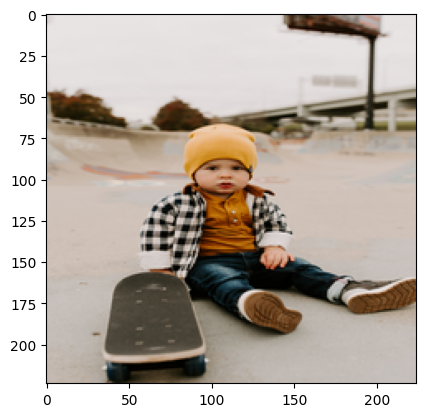

Predicted caption:
 a man in a surfboard stares at a chili dog with cheese endsentence



In [86]:
#translate("/Users/dino/Documents/info7610/flickr8k/Flickr8k_Dataset/141139674_246c0f90a1.jpg")
translate("/Users/mengyue/Desktop/24Spring/INFO6106/W9L2coco/95A2204.jpg")

## Vacation pics

1/1 [==============================] - 0s 23ms/step


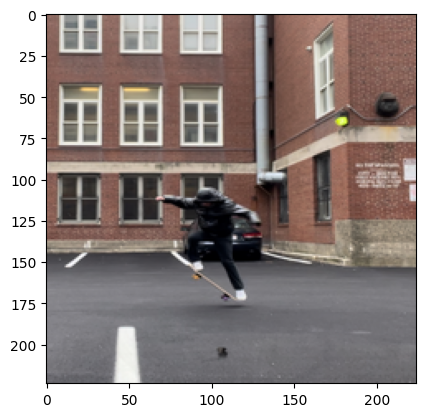

Predicted caption:
 a man is doing a trick on a skateboard endsentence



In [87]:
translate("no-time-for-vacation.jpg") 

it's quite precise though it is a female lol

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


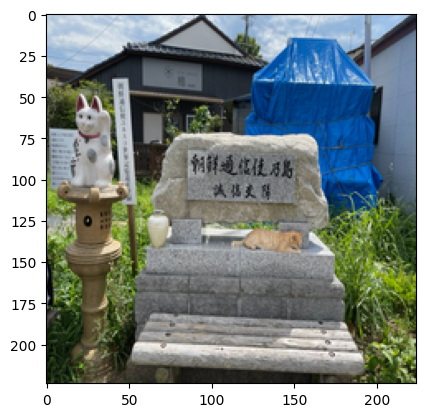

Predicted caption:
 a man standing in a costume talking on a cell phone endsentence



In [93]:
translate("fukuoka.jpg")

lol 

In [142]:
def test_translation(idx, train=False):
    """
    Generate a caption for an image in your corpus.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        # use this for coco
        coco_dir = '/Users/mengyue/Desktop/24Spring/INFO6106/W9L2coco/coco/train2017'
        filename = train_filenames[idx]
        caption = train_captions[idx]
    else:
        # Use image and captions from the validation-set.       
        # use this for coco
        coco_dir = val_images_path
        filename = val_filenames[idx]
        caption = val_captions[idx] 


    # Path for the image-file.
    # use this for coco
    path = os.path.join(coco_dir, filename)
    # use this for flickr8k
    # path = os.path.join(train_images_path, filename) if train else os.path.join(val_images_path, filename)

    # Use the model to generate a caption of the image.
    translate(image_path=path)

    # Print the true captions from the data-set.
    #print("True captions:")
    #for caption in captions:
    #    print(caption)
    print("True caption: ", caption)

predict on test set

1/1 [==============================] - ETA: 0s

d:\Anaconda3.5.1\envs\conx2\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1/1 [==============================] - 0s 53ms/step


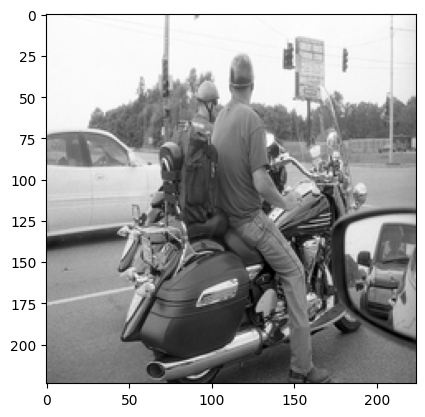

Predicted caption:
 a plan sits on the motorcycle with a street endsentence

True caption:  Two men on motorcycles at a stop light


In [ ]:
test_translation(idx=100, train=True)

# With Inception V3

## Translating images to text using *Bahdenau Attention*



Instead of `VGG16`, we will preprocess and cache a subset of images using the `Inception V3` CNN stack, train an encoder-decoder model, and generate captions on new images using the trained model.




In [94]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [98]:
len(train_filenames_mini), len(train_captions_mini)

(1000, 1000)

In [99]:
img_name_vector = []
train_captions = train_captions_mini
for i in range(len(train_filenames_mini)):
    img_name_vector.append('coco/train2017/' + train_filenames_mini[i])

In [100]:
len(train_captions), len(img_name_vector)

(1000, 1000)

Always verify your images are aligned with your captions, by opening the image file and verifying the caption is the correct one:

In [101]:
train_captions[500], img_name_vector[500]

('Pancakes on a plate with banana, sauce and whipped cream toppings',
 'coco/train2017/000000321079.jpg')

## Preprocessing the images using Inception V3
Let's use InceptionV3 (which is pretrained on [Imagenet](http://www.image-net.org/)) to classify each image. We'll also extract features from the last convolutional layer.

So we need to convert the images into InceptionV3's expected format by resizing the images to 299 pixels by 299 pixels.

In [95]:
def load_image(image_path):
    #print('load_image: ', image_path)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [96]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

This is our new model:

In [151]:
image_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

## Caching the features extracted from Inception V3
Let's pre-process each image with InceptionV3 and cache the output to disk, just as we did with our RNN.

Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. This exceeds the memory limitations of Colab (currently 12GB of memory) and may also exceed your own laptop's RAM.

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

In [102]:
len(img_name_vector)

1000

Let's run all our images through Inception to generate each image's **thought vector**, and store each in an `.npy` file.

We are going to read images into Inception in batches. I use batch number 16. But you could change that to 32 for example.

We are going to use a different caching strategy than before:

In [103]:
len(img_name_vector), img_name_vector[0]

(1000, 'coco/train2017/000000391895.jpg')

In [104]:
# Get unique images
#encode_train = sorted(set(img_name_vector))
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [105]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [106]:
example_path = ''
for img, path in image_dataset:
    print(img, path)
    example_path = path[10]
    break

tf.Tensor(
[[[[ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   ...
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]]

  [[ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   ...
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]]

  [[ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   ...
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]
   [ 1.          1.          1.        ]]

  ...

  [[ 0.07153571 -0.20143962 -0.35911745]
   [ 0.41787887  0.16716409 -0.22405732]
   [ 0.46443546  0.22534394 -0.05119044]
   ...
   [-0.62330407 -0.54130876 -0.9591519 ]
   [-0.3896513  -0.36615378 -0.6969954 ]
   [-

In [107]:
example_path = example_path.numpy().decode()
example_path

'coco/train2017/000000118113.jpg'

In [108]:
example_path[0:img_name_vector[0].rindex('/')] + '.npy' + example_path[img_name_vector[0].rindex('/'):]

'coco/train2017.npy/000000118113.jpg'

In [109]:
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        print(path_of_feature)
        print(path_of_feature[0:path_of_feature.rindex('/')] + '.npy' + path_of_feature[path_of_feature.rindex('/'):])
        break
    break

coco/train2017/000000391895.jpg
coco/train2017.npy/000000391895.jpg


First, create a folder called `2017.npy` at the same level as your COCO train2017 folder.

Then:

In [110]:
len(image_dataset)

63

In [111]:
from tqdm import tqdm

The shape of the vector output from InceptionV3 is (64, 2048):

In [112]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    print(batch_features.shape)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    print(batch_features.shape)
    break

  0%|          | 0/63 [00:00<?, ?it/s]

(16, 8, 8, 2048)
(16, 64, 2048)


In [113]:
image_features_extract_model(img)

<tf.Tensor: shape=(16, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.54202127e-01, 0.00000000e+00, ...,
          0.00000000e+00, 1.61199057e+00, 3.85557022e-03],
         [0.00000000e+00, 0.00000000e+00, 8.12281966e-02, ...,
          0.00000000e+00, 1.05909407e+00, 4.64348912e-01],
         [0.00000000e+00, 0.00000000e+00, 1.12883151e-01, ...,
          0.00000000e+00, 9.32134271e-01, 1.07680225e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.65151829e-01, 3.34831655e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.21989120e-02, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 7.34836578e-01, ...,
          2.18123704e-01, 1.30833125e+00, 0.00000000e+00],
         [0.00000000e+00, 1.18023872e-01, 1.75413680e+00, ...,
         

In [166]:
from tqdm import tqdm

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        new_path_of_feature = path_of_feature[0:path_of_feature.rindex('/')] + '.npy' + path_of_feature[path_of_feature.rindex('/'):]
        np.save(new_path_of_feature, bf.numpy())

  5%|▍         | 3/63 [00:02<00:54,  1.11it/s]100%|██████████| 63/63 [00:49<00:00,  1.26it/s]


## Preprocess and tokenize the captions
First, we tokenize the captions by splitting on spaces. 

This gives us a vocabulary of all of the unique words in the target language (`surfing`, `football`, etc.).

Next, we limit the vocabulary size to the top 5,000 words (to save memory). We replace all other words with the token "UNK" (unknown).

We then create word-to-index and index-to-word mappings, and pad all sequences to be the same length as the longest one.

SOP, you should be used to all this by now!

In [114]:
len(train_captions), len(img_name_vector)

(1000, 1000)

In [115]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

Add the start and end tokens:

In [116]:
'<start> ' + train_captions[0] + ' <end>'

'<start> A man in a red shirt and a red hat is on a motorcycle on a hill side. <end>'

In [117]:
train_captions_wrapped = []
for c in train_captions:
    train_captions_wrapped.append('<start> ' + c + ' <end>')
    
train_captions_wrapped[0]

'<start> A man in a red shirt and a red hat is on a motorcycle on a hill side. <end>'

In [118]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions_wrapped)
train_seqs = tokenizer.texts_to_sequences(train_captions_wrapped)

In [119]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [120]:
len(train_captions_wrapped), train_captions_wrapped[500], 

(1000,
 '<start> Pancakes on a plate with banana, sauce and whipped cream toppings <end>')

Let's create our tokenized vectors

In [121]:
train_seqs = tokenizer.texts_to_sequences(train_captions_wrapped)

In [122]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [159]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

25

In [123]:
len(cap_vector[0]), cap_vector[0]

(25,
 array([  3,   2,  14,   8,   2,  49, 258,  10,   2,  49, 259,  11,   5,
          2, 113,   5,   2, 232,  83,   4,   0,   0,   0,   0,   0],
       dtype=int32))

## Test/validation set

In [124]:
len(img_name_vector), len(cap_vector)

(1000, 1000)

In [125]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.1,
                                                                    random_state=0)

In [126]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(900, 900, 100, 100)

In [127]:
img_name_train[400:402], tokenizer.sequences_to_texts(cap_train[400:402])

(['coco/train2017/000000201925.jpg', 'coco/train2017/000000290570.jpg'],
 ['<start> a cake in a pan sitting on the rack of an oven <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>',
  '<start> sheep are grazing in a snow dusted field <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'])

## Creating a `tf.data` dataset for training
Let's create a `tf.data` dataset to use for training our model.

In [128]:
# You can change these parameters according to your system's configuration
#BATCH_SIZE = 64
BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [129]:
name = 'coco/train2017/0000134.jpg'
new_name = name[0:name.rindex('/')] + '.npy' + name[name.rindex('/'):] + '.npy'
new_name

'coco/train2017.npy/0000134.jpg.npy'

In [130]:
# Load the numpy files
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    name = img_name.decode('utf-8')
    new_name = name[0:name.rindex('/')] + '.npy' + name[name.rindex('/'):] + '.npy'
    img_tensor = np.load(new_name)
    return img_tensor, cap

In [131]:
len(img_name_train), len(cap_train)

(900, 900)

In [132]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Bahdenau Attention Model

We will use a Bahdanau Attention model (a.k.a. *additive Attention*) decoder. The model architecture is from [here](https://arxiv.org/pdf/1502.03044.pdf).

Let's extract features from the last convolutional layer of InceptionV3, giving us a vector of shape (8, 8, 2048).

Then squash that to a shape of (64, 2048).

This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer since we already did the CNN processing using Inception V3).

We will use a GRU RNN to attend over the image and predict the next word.

This is our additive Attention layer:

In [133]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [134]:
embedding_dim

256

In [135]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [136]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # new new new
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

Let's instantiate our encoder and decoder:

In [137]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

Optimizer and loss function:

In [138]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [139]:
#checkpoint_path = "data/training_checkpoints/inception"
#checkpoint_path = '/Users/dino/Documents/info7610/checkpoints/inception'
checkpoint_path = 'checkpoints/bahdanau'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [140]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [141]:
loss_plot = []

just for the sake of cheking dim

In [142]:
for (batch, (img_tensor, target)) in enumerate(dataset):
    
    print('img_tensor, target:', img_tensor.shape, target.shape)
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    print('hidden:', hidden.shape)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    print('dec_input:', dec_input.shape)
    
    features = encoder(img_tensor)
    print('features', features.shape)
    
    predictions, hidden, junk = decoder(dec_input, features, hidden)
    print('predictions, hidden, junk:', predictions.shape, hidden.shape, junk.shape)
    
    print('target[:, 1]:', target[:, 1].shape)
    loss = loss_function(target[:, 1], predictions)
    print('loss:', loss.numpy())
    
    dec_input = tf.expand_dims(target[:, 1], 1)
    print('dec_input:', dec_input.shape)
    
    break

img_tensor, target: (16, 64, 2048) (16, 25)
hidden: (16, 512)
dec_input: (16, 1)
features (16, 64, 256)
predictions, hidden, junk: (16, 5001) (16, 512) (16, 64, 1)
target[:, 1]: (16,)
loss: 2.9802315e-08
dec_input: (16, 1)


In [143]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Now we're ready for our training loop.

In [216]:
EPOCHS = 20000

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.1077
Epoch 1 Loss 0.116051
Time taken for 1 epoch 12.114941835403442 sec

Epoch 2 Batch 0 Loss 0.1190
Epoch 2 Loss 0.105491
Time taken for 1 epoch 12.196640014648438 sec

Epoch 3 Batch 0 Loss 0.1211
Epoch 3 Loss 0.094180
Time taken for 1 epoch 11.92770504951477 sec

Epoch 4 Batch 0 Loss 0.0700
Epoch 4 Loss 0.089520
Time taken for 1 epoch 11.991582870483398 sec

Epoch 5 Batch 0 Loss 0.0494
Epoch 5 Loss 0.081369
Time taken for 1 epoch 10.780964136123657 sec

Epoch 6 Batch 0 Loss 0.0837
Epoch 6 Loss 0.071385
Time taken for 1 epoch 11.782298803329468 sec

Epoch 7 Batch 0 Loss 0.0888
Epoch 7 Loss 0.064905
Time taken for 1 epoch 11.837278127670288 sec

Epoch 8 Batch 0 Loss 0.0848
Epoch 8 Loss 0.068953
Time taken for 1 epoch 11.704154968261719 sec

Epoch 9 Batch 0 Loss 0.0452
Epoch 9 Loss 0.058946
Time taken for 1 epoch 11.391635179519653 sec

Epoch 10 Batch 0 Loss 0.0189
Epoch 10 Loss 0.054742
Time taken for 1 epoch 10.868767976760864 sec

Epoch 11 Batch 0 Loss 0.0312


KeyboardInterrupt: 

### We trained 2023 epochs 

In [ ]:
EPOCHS = 0

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Let's plot our training loss throughout our training:

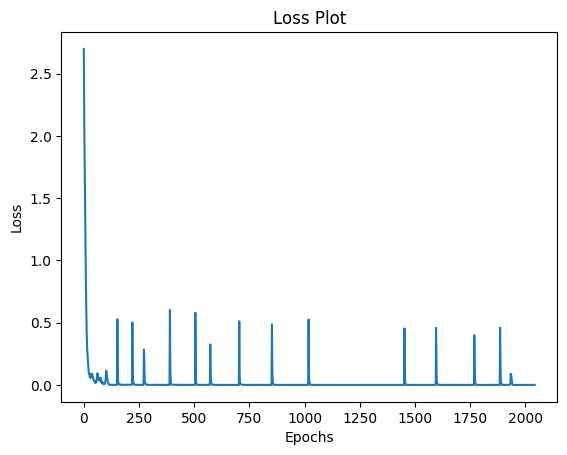

In [218]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Inference 

In [152]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [153]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Let's select an image at random from our evaluation dataset, translate it, and compare translation with the original caption:

In [154]:
len(img_name_val)

100

In [155]:
img_name_val[10]

'coco/train2017/000000263136.jpg'

In [156]:
cap_val[10]

array([   3,    6,  564,   11, 1139,   51,    6, 1140,    7,    6,  104,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [157]:
' '.join([tokenizer.index_word[i] for i in cap_val[10] if i not in [0]])

'<start> the bride is impressed by the grace of the horse <end>'

Real Caption: <start> the bride is impressed by the grace of the horse <end>
Prediction Caption: horses next to drink water in a polka lane <end>


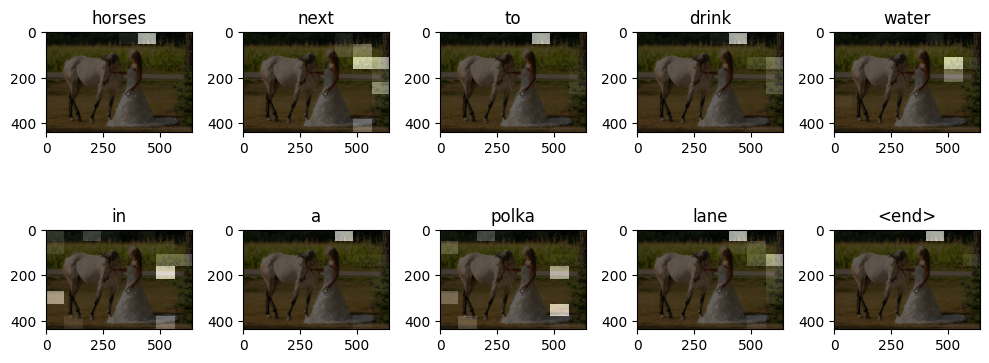

coco/train2017/000000263136.jpg


In [160]:
# captions on the validation set
#rid = np.random.randint(0, len(img_name_val))
#image = img_name_val[rid]
image = img_name_val[10]
#rea1l_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[10] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
print(image)

## Vacation pic

Prediction caption: a woman on a clock ball with a clock on a building <end>


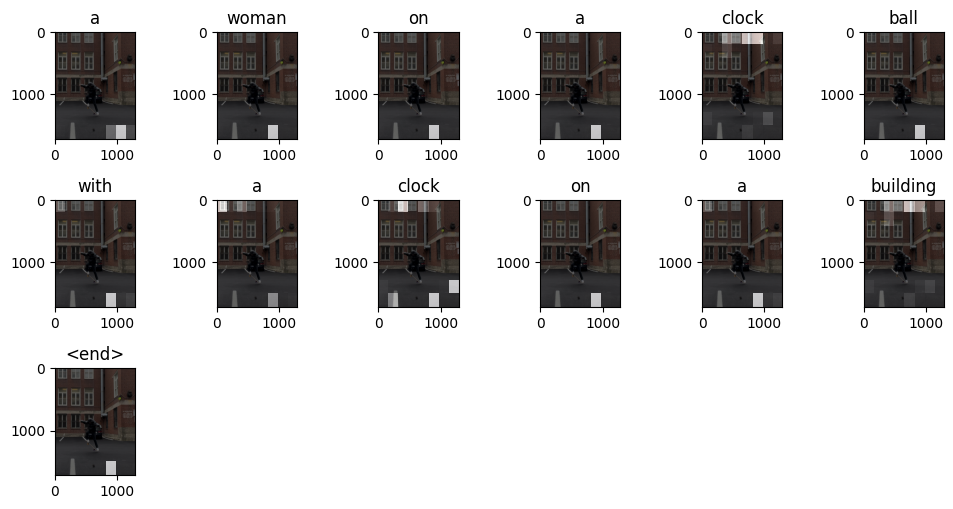

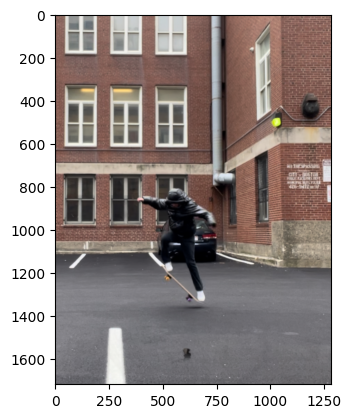

In [167]:



image_path = 'no-time-for-vacation.jpg'

 
result, attention_plot = evaluate(image_path)
print('Prediction caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
 
img = Image.open(image_path)
plt.imshow(img)
plt.show()


it recognize a woman 

Prediction caption: a red fire hydrant spouting water <end>


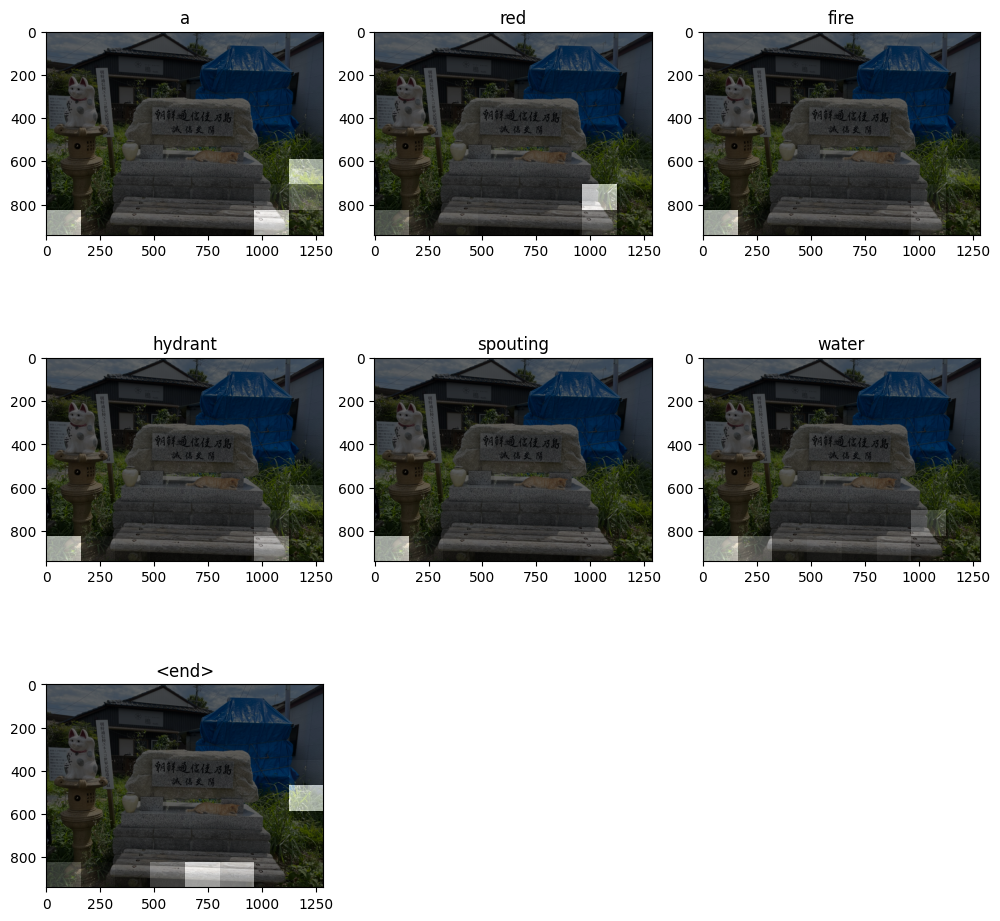

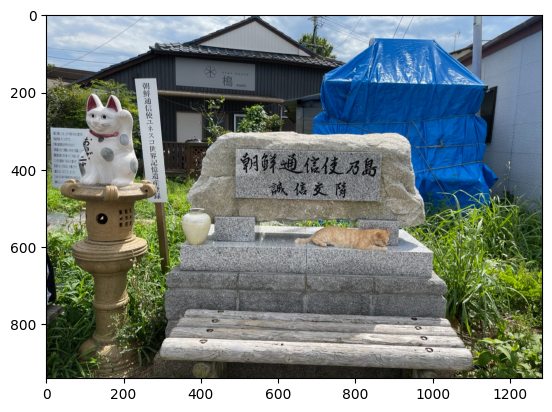

In [168]:

image_path = 'fukuoka.jpg'

 
result, attention_plot = evaluate(image_path)
print('Prediction caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
 
img = Image.open(image_path)
plt.imshow(img)
plt.show()


...

## img from url

Let's find a picture on the Web of two dogs playing on the beach, and translate it:

Prediction caption: a person walking down on the beach <end>


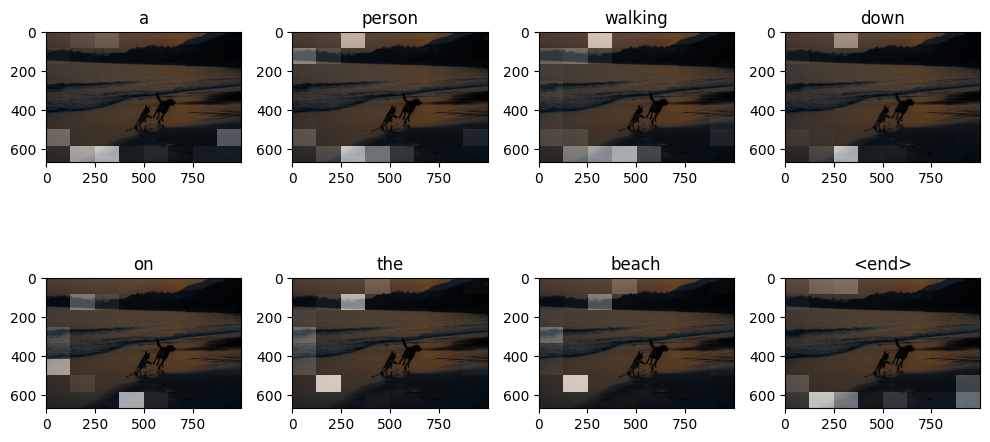

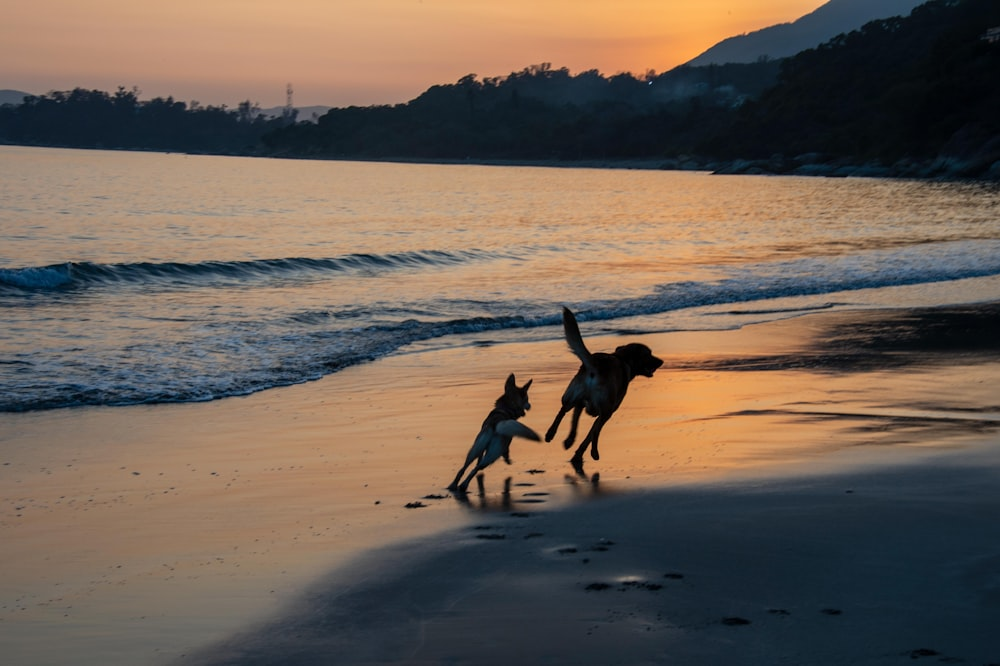

In [164]:
#image_url = 'https://www.hillspet.com/content/dam/cp-sites/hills/hills-pet/en_us/exported/dog-care/Skyword/images/two-dogs-on-beach-at-sunset-SW.jpg'
image_url = 'https://images.unsplash.com/photo-1647479458842-8b39b20758d0?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1yZWxhdGVkfDExfHx8ZW58MHx8fHx8&w=1000&q=80'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
        
result, attention_plot = evaluate(image_path)
print ('Prediction caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)

# opening the image and compare translation with the image itself
Image.open(image_path)

# Conclusion

We trained 840 epochs(5hrs) on the model based on vgg, and 2023 epochs(8hrs) on the model based on Inception V3.

Both on the M1 chip, which is a unified architecture combining CPU, GPU

By using different pretrained models VGG and Inception V3 as the feature extraction component of an image captioning system seperatly in the two models we established to change the model architecture. 

Training more epochs would improve the accuracy but the model predicting performance is not 'stable', even Inception V3 shall be baetter for captioning task, with our vacation pic, it doesn't necessarily outperform the vgg one.